Fitting 5 folds for each of 16 candidates, totalling 80 fits
✅ Best Hyperparameters: {'regressor__max_depth': 20, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
📉 Mean Squared Error on test set: 29324.63
📈 R² Score on test set: 0.9371

🔄 4-Fold Cross-Validation MSE scores: [62494.66134167 18462.95141798 51337.15434732 95845.39947946]
🧮 Average 4-Fold CV MSE: 57035.04


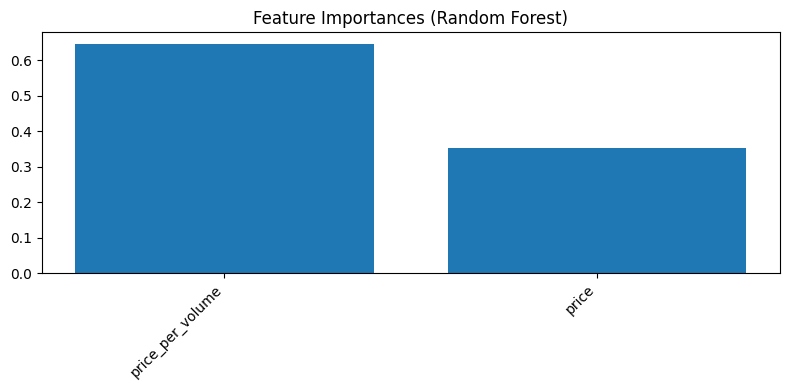

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("cleaned_zara.csv", delimiter=",")

# Drop irrelevant columns
drop_cols = ['Product ID', 'url', 'sku', 'name', 'description', 'scraped_at', 'terms', 'section', 'currency']
df = df.drop(columns=drop_cols, errors='ignore')

# Drop missing values
df = df.dropna()

# --- Feature Engineering ---

# Binary features (not used here since we're only using price and price_per_volume)
# df['is_promo'] = df['Promotion'].map({'Yes': 1, 'No': 0})
# df['is_seasonal'] = df['Seasonal'].map({'Yes': 1, 'No': 0})

# Simplify brand (not used here)
# top_brands = df['brand'].value_counts().nlargest(3).index
# df['brand_grouped'] = df['brand'].apply(lambda x: x if x in top_brands else 'Other')

# Price per volume (add 1 to avoid divide-by-zero)
df['price_per_volume'] = df['price'] / (df['Sales Volume'] + 1)

# Remove outliers in target using 5th and 95th percentiles
lower = df['Sales Volume'].quantile(0.05)
upper = df['Sales Volume'].quantile(0.95)
df = df[(df['Sales Volume'] >= lower) & (df['Sales Volume'] <= upper)]

# --- Define features and target ---

target = 'Sales Volume'
features = ['price_per_volume', 'price']
X = df[features]
y = df[target]

# No categorical features here, so no preprocessing needed

# Pipeline with Random Forest (no preprocessing step needed)
pipeline = Pipeline(steps=[
    ('regressor', RandomForestRegressor(random_state=42))
])

# Hyperparameter tuning grid
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

# Grid search setup
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best model and evaluation on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("✅ Best Hyperparameters:", grid_search.best_params_)
print(f"📉 Mean Squared Error on test set: {mse:.2f}")
print(f"📈 R² Score on test set: {r2:.4f}")

# --- 4-Fold Cross Validation on the best model ---

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

cv_scores = cross_val_score(best_model, X, y, cv=4, scoring=mse_scorer, n_jobs=-1)
mse_scores = -cv_scores  # Convert negative MSE to positive

print(f"\n🔄 4-Fold Cross-Validation MSE scores: {mse_scores}")
print(f"🧮 Average 4-Fold CV MSE: {np.mean(mse_scores):.2f}")

# --- Feature importance plotting ---

best_rf = best_model.named_steps['regressor']

importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

n_features = len(features)
plt.figure(figsize=(8, 4))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(n_features), importances[indices[:n_features]], align="center")
plt.xticks(range(n_features), [features[i] for i in indices[:n_features]], rotation=45, ha='right')
plt.tight_layout()
plt.show()
